# 1. Making classification data

In [2]:
from importlib.metadata import distributions

from sklearn.datasets import make_circles

In [7]:
n_samples = 1000
X, y = make_circles(n_samples=n_samples, random_state=42, noise=0.03)

In [8]:
X[:10], y[:10]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343],
        [-0.47964637,  0.67643477],
        [-0.01364836,  0.80334872],
        [ 0.77151327,  0.14775959],
        [-0.16932234, -0.79345575],
        [-0.1214858 ,  1.02150905]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [9]:
import pandas as pd
circles = pd.DataFrame({
    'X1': X[:, 0],
    'X2': X[:, 1],
    'labels': y
})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


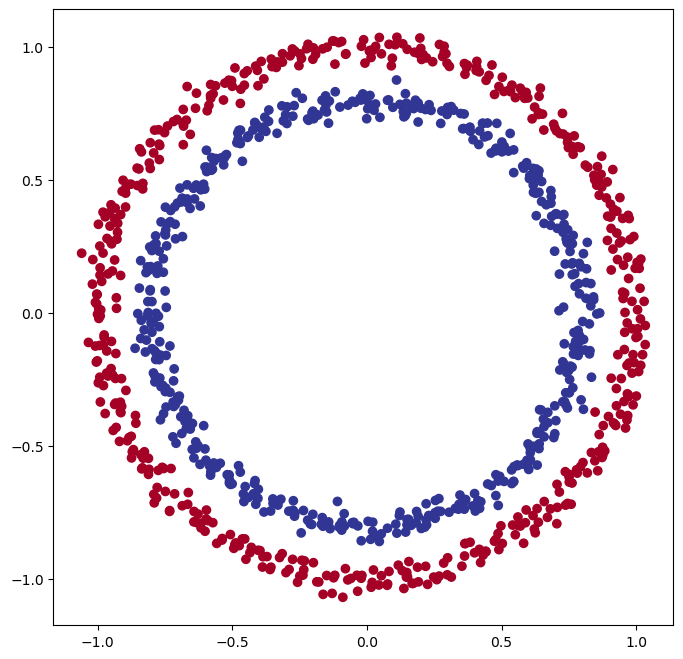

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.show();

## Input and output shapes

In [16]:
X.shape, y.shape

((1000, 2), (1000,))

## Turn into tensors and create train test split

In [18]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Building a model

In [21]:
import torch
from torch import nn

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device, torch.__version__

('mps', '2.5.1')

In [22]:
class CircleNetV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

In [23]:
model_0 = CircleNetV0().to(device)
model_0

CircleNetV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [24]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [25]:
untrained_preds = model_0(X_test.to(device))

tensor([[ 0.3046],
        [ 0.2876],
        [ 0.1911],
        [ 0.3374],
        [-0.0596],
        [-0.0680],
        [ 0.0830],
        [-0.0010],
        [ 0.2018],
        [ 0.2837]], device='mps:0', grad_fn=<SliceBackward0>)

In [26]:
print(f'First 10 predictions: {untrained_preds[:10]}')

First 10 predictions: tensor([[ 0.3046],
        [ 0.2876],
        [ 0.1911],
        [ 0.3374],
        [-0.0596],
        [-0.0680],
        [ 0.0830],
        [-0.0010],
        [ 0.2018],
        [ 0.2837]], device='mps:0', grad_fn=<SliceBackward0>)


In [27]:
## Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [28]:
## Evaluation Metrics
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [30]:
## Let's use sample model prediction to see how it works
y_logits = model_0(X_test[:5].to(device))
print(y_logits)

tensor([[ 0.3046],
        [ 0.2876],
        [ 0.1911],
        [ 0.3374],
        [-0.0596]], device='mps:0', grad_fn=<LinearBackward0>)


In [31]:
y_pred_probs = torch.sigmoid(y_logits)
print(y_pred_probs)

tensor([[0.5756],
        [0.5714],
        [0.5476],
        [0.5836],
        [0.4851]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [32]:
y_preds = torch.round(y_pred_probs)
print(y_preds)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='mps:0', grad_fn=<RoundBackward0>)


In [33]:
print(y_preds.squeeze())

tensor([1., 1., 1., 1., 0.], device='mps:0', grad_fn=<SqueezeBackward0>)


In [34]:
# Oneliner approach
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.]], device='mps:0', grad_fn=<RoundBackward0>)


In [35]:
print(y_pred_labels.squeeze())

tensor([1., 1., 1., 1., 0.], device='mps:0', grad_fn=<SqueezeBackward0>)


## Building Training and Testing Loop

In [37]:
torch.manual_seed(42)

# Number of epochs
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Put in training mode
    model_0.train()
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # Since we are Using BCEWithLogitsLoss
    accuracy = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Eval mode
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_accuracy = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss:.4f}, accuracy: {accuracy:.4f} | Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}')

Epoch 0, loss: 0.6975, accuracy: 52.6250 | Test loss: 0.6999, Test accuracy: 52.5000
Epoch 10, loss: 0.6972, accuracy: 52.8750 | Test loss: 0.6995, Test accuracy: 52.0000
Epoch 20, loss: 0.6969, accuracy: 52.5000 | Test loss: 0.6992, Test accuracy: 52.5000
Epoch 30, loss: 0.6967, accuracy: 52.1250 | Test loss: 0.6989, Test accuracy: 52.5000
Epoch 40, loss: 0.6965, accuracy: 52.2500 | Test loss: 0.6987, Test accuracy: 51.5000
Epoch 50, loss: 0.6963, accuracy: 51.7500 | Test loss: 0.6985, Test accuracy: 51.5000
Epoch 60, loss: 0.6961, accuracy: 51.7500 | Test loss: 0.6982, Test accuracy: 52.0000
Epoch 70, loss: 0.6960, accuracy: 51.1250 | Test loss: 0.6980, Test accuracy: 52.5000
Epoch 80, loss: 0.6958, accuracy: 51.3750 | Test loss: 0.6979, Test accuracy: 53.5000
Epoch 90, loss: 0.6957, accuracy: 51.3750 | Test loss: 0.6977, Test accuracy: 53.5000


In [44]:
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None: plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

In [48]:
import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

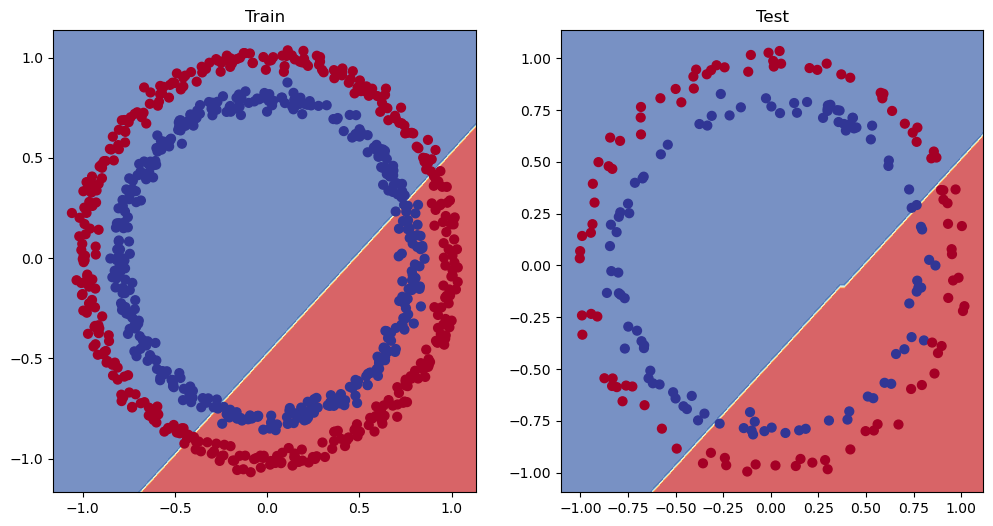

In [49]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [51]:
# Define Another Model
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1),
)
model_1.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [52]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [53]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69528, Accuracy: 51.38% | Test loss: 0.69252, Test acc: 50.50%
Epoch: 100 | Loss: 0.69325, Accuracy: 47.88% | Test loss: 0.69283, Test acc: 51.00%
Epoch: 200 | Loss: 0.69309, Accuracy: 49.88% | Test loss: 0.69344, Test acc: 46.50%
Epoch: 300 | Loss: 0.69303, Accuracy: 50.50% | Test loss: 0.69384, Test acc: 47.50%
Epoch: 400 | Loss: 0.69300, Accuracy: 51.38% | Test loss: 0.69412, Test acc: 46.50%
Epoch: 500 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69431, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69444, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69452, Test acc: 45.50%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.50% | Test loss: 0.69458, Test acc: 44.50%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69461, Test acc: 45.00%


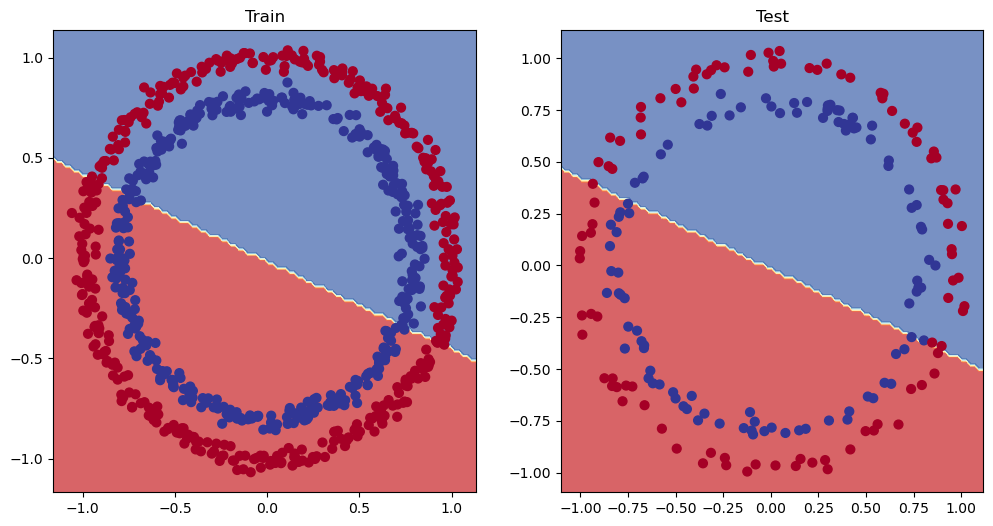

In [54]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [60]:
## Building Non Linear Model
model_3 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1),
)
model_3.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [62]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [63]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70316, Accuracy: 50.00% | Test Loss: 0.70407, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68960, Accuracy: 52.00% | Test Loss: 0.69267, Test Accuracy: 47.50%
Epoch: 200 | Loss: 0.68574, Accuracy: 62.62% | Test Loss: 0.68958, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.68095, Accuracy: 64.12% | Test Loss: 0.68594, Test Accuracy: 57.50%
Epoch: 400 | Loss: 0.67364, Accuracy: 63.25% | Test Loss: 0.68004, Test Accuracy: 58.00%
Epoch: 500 | Loss: 0.66177, Accuracy: 69.50% | Test Loss: 0.66909, Test Accuracy: 62.00%
Epoch: 600 | Loss: 0.64147, Accuracy: 77.50% | Test Loss: 0.64814, Test Accuracy: 73.00%
Epoch: 700 | Loss: 0.60521, Accuracy: 84.88% | Test Loss: 0.61084, Test Accuracy: 83.50%
Epoch: 800 | Loss: 0.54166, Accuracy: 95.62% | Test Loss: 0.54904, Test Accuracy: 93.50%
Epoch: 900 | Loss: 0.43424, Accuracy: 99.38% | Test Loss: 0.45132, Test Accuracy: 99.00%


In [64]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

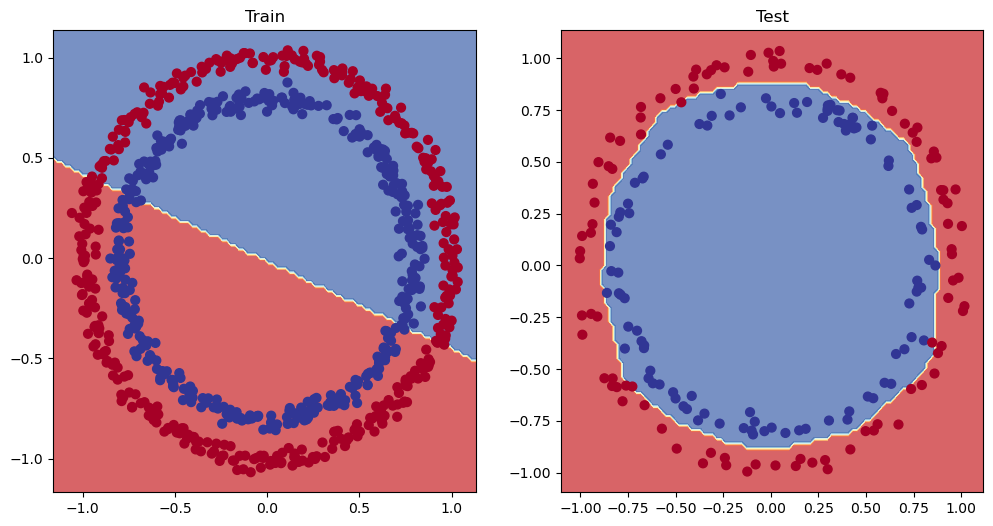

In [65]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

# Putting together everything by Building a Multi-class PyTorch model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


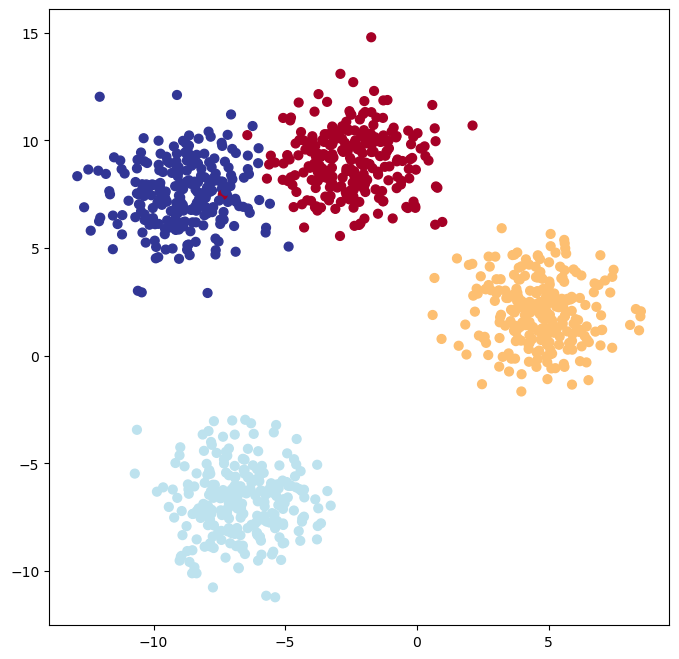

In [69]:
# Importing dependencies
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# data creation hyperparameters
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create a multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)
plt.figure(figsize=(8,8))
plt.scatter(X_blob[:, 0], X_blob[:,1], c=y_blob, s=40, cmap=plt.cm.RdYlBu);

In [76]:
# Create device-agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [96]:
# Building the model
class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()
        self.linear_stack_layer = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units, bias=True),
            nn.Linear(in_features=hidden_units, out_features=hidden_units, bias=True),
            nn.Linear(in_features=hidden_units, out_features=out_features, bias=True),
        )

    def forward(self, x):
        return self.linear_stack_layer(x)

In [97]:
model_4 = BlobModel(in_features=NUM_FEATURES, out_features=NUM_CLASSES, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_stack_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [98]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [99]:
pew = model_4(X_blob_train.to(device))

In [100]:
print(pew[:5])

tensor([[ 0.3072, -0.4649,  0.9707,  0.3220],
        [ 0.2476, -0.2528,  1.2909, -0.6588],
        [ 0.9263,  0.5522, -1.3635,  0.9800],
        [ 0.7400,  0.3009, -0.6444,  0.6201],
        [ 0.3316, -0.1536,  0.9620, -0.4542]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [102]:
pew.shape[1], NUM_CLASSES

(4, 4)

## We have to go from logit -> prediction probabilities -> prediction labels

In [104]:
# We are going to use softmax function for our classes
y_logits = model_4(X_blob_train.to(device))
# Perform softmax calculation on logits across dim 1 / columns
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.3072, -0.4649,  0.9707,  0.3220],
        [ 0.2476, -0.2528,  1.2909, -0.6588],
        [ 0.9263,  0.5522, -1.3635,  0.9800],
        [ 0.7400,  0.3009, -0.6444,  0.6201],
        [ 0.3316, -0.1536,  0.9620, -0.4542]], device='mps:0',
       grad_fn=<SliceBackward0>)
tensor([[0.2263, 0.1046, 0.4394, 0.2297],
        [0.2062, 0.1250, 0.5854, 0.0833],
        [0.3516, 0.2419, 0.0356, 0.3710],
        [0.3594, 0.2317, 0.0900, 0.3188],
        [0.2532, 0.1559, 0.4756, 0.1154]], device='mps:0',
       grad_fn=<SliceBackward0>)


In [105]:
# What this means is
torch.sum(y_pred_probs[0]) # It should print 1

tensor(1., device='mps:0', grad_fn=<SumBackward0>)

> Basically we are putting the probability distribution for classes

In [107]:
print(y_pred_probs[0])
print(f'The maximum : {torch.argmax(y_pred_probs[0])}')

tensor([0.2263, 0.1046, 0.4394, 0.2297], device='mps:0',
       grad_fn=<SelectBackward0>)
The maximum : 2


## Training and testing

In [110]:
torch.manual_seed(42)
epochs = 1000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        test_loss = loss_fn(test_logits, y_blob_test)
        test_accuracy = accuracy_fn(y_true=y_blob_test,y_pred=test_pred)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Training Loss: {loss:.5f}, Training Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_accuracy:.5f}')

Epoch: 0 | Training Loss: 0.03419, Training Accuracy: 99.00% | Test Loss: 0.02537, Test Accuracy: 99.50000
Epoch: 100 | Training Loss: 0.02853, Training Accuracy: 99.12% | Test Loss: 0.01859, Test Accuracy: 99.50000
Epoch: 200 | Training Loss: 0.02693, Training Accuracy: 99.12% | Test Loss: 0.01635, Test Accuracy: 99.50000
Epoch: 300 | Training Loss: 0.02613, Training Accuracy: 99.12% | Test Loss: 0.01516, Test Accuracy: 99.50000
Epoch: 400 | Training Loss: 0.02560, Training Accuracy: 99.12% | Test Loss: 0.01439, Test Accuracy: 99.50000
Epoch: 500 | Training Loss: 0.02519, Training Accuracy: 99.12% | Test Loss: 0.01382, Test Accuracy: 99.50000
Epoch: 600 | Training Loss: 0.02485, Training Accuracy: 99.25% | Test Loss: 0.01337, Test Accuracy: 99.50000
Epoch: 700 | Training Loss: 0.02455, Training Accuracy: 99.25% | Test Loss: 0.01300, Test Accuracy: 99.50000
Epoch: 800 | Training Loss: 0.02428, Training Accuracy: 99.25% | Test Loss: 0.01268, Test Accuracy: 99.50000
Epoch: 900 | Training

In [111]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)
print(y_logits[:10])

tensor([[  9.4226,  22.2393, -20.1193, -11.0719],
        [  6.0494, -27.4454,   1.9317,  14.3233],
        [-12.7504, -26.3836,  28.0907,  14.0205],
        [  4.4880,  17.0013, -11.3333,  -8.3365],
        [ 14.5142,   5.2546, -21.3932,  -2.4700],
        [  6.4530, -34.0932,   3.6756,  17.7103],
        [-12.7824, -19.2780,  25.6630,  10.3951],
        [ 11.9470,  -3.3168, -14.7876,   1.9363],
        [-13.8253, -37.9821,  33.6439,  19.9524],
        [ 12.6654,  -0.1387, -16.9074,   0.3055]], device='mps:0')


In [113]:
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
print(f'Predictions: {y_preds[:10]}')
print(f'Original Labels: {y_blob_test[:10]}')

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')
Original Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')


In [114]:
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Test accuracy: 99.5%


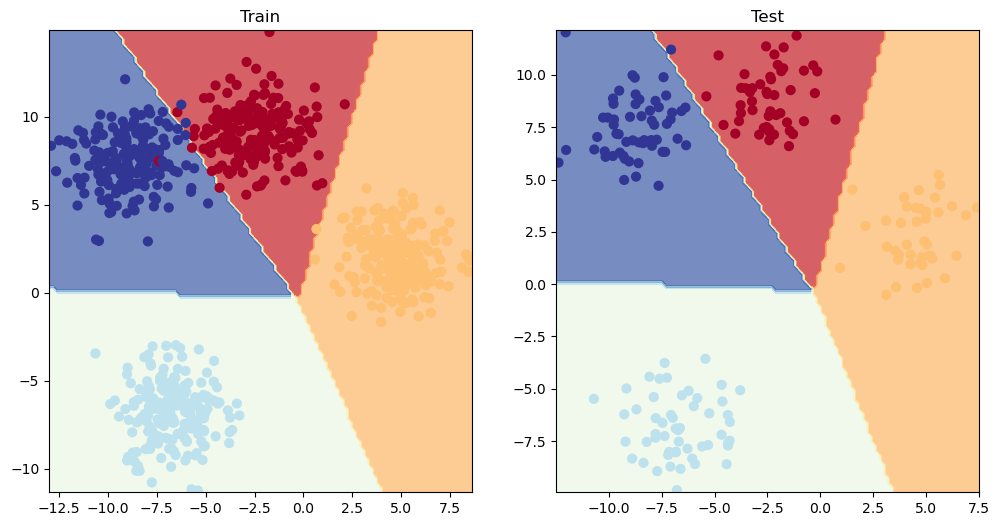

In [115]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)